# Dimensionality Reduction

## PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from utils.plots import plot_digits
from sklearn.decomposition import IncrementalPCA

### Data

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

<ipython-input-3-bd13b60726a3>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


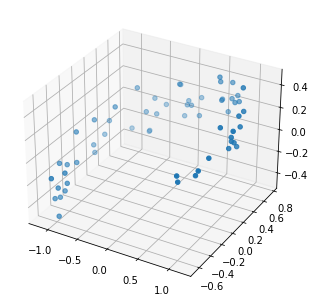

In [3]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

### Using Numpy

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

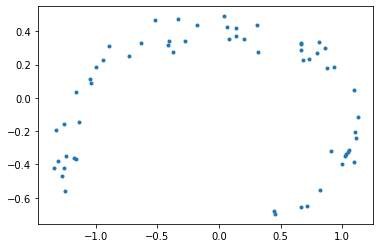

In [6]:
plt.plot(X2D[:, 0], X2D[:, 1], '.')

### using scikit-learn

In [7]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

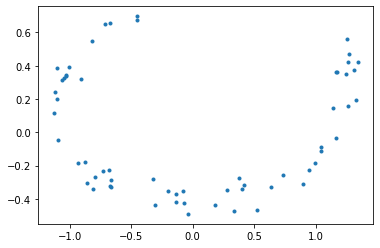

In [8]:
plt.plot(X2D[:, 0], X2D[:, 1], '.')

In [9]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### Choosing the right number of dimensions

In [10]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [11]:
X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

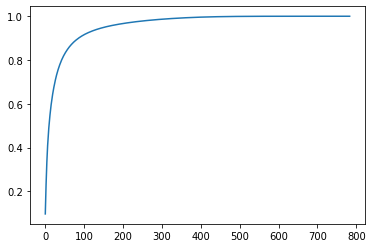

In [13]:
plt.plot(cumsum)

### PCA for Compression

In [14]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'compressed')

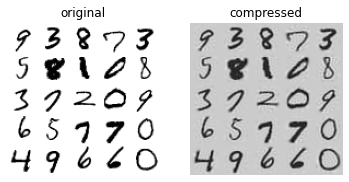

In [15]:
plt.subplot(121)
plot_digits(X_train[::2100], 5)
plt.title('original')
plt.subplot(122)
plot_digits(X_recovered[::2100], 5)
plt.title('compressed')

### Randomized PCA

In [16]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'compressed')

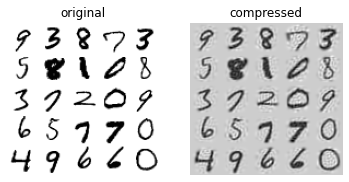

In [17]:
plt.subplot(121)
plot_digits(X_train[::2100], 5)
plt.title('original')
plt.subplot(122)
plot_digits(X_recovered[::2100], 5)
plt.title('compressed')

### Incremental PCA

In [18]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

In [19]:
X_reduced = inc_pca.transform(X_train)

## Kernel PCA

In [71]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.manifold import LocallyLinearEmbedding

In [46]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

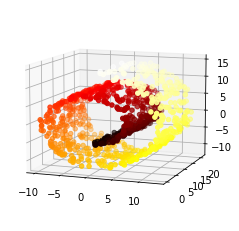

In [58]:
axes = [-11.5, 14, -2, 23, -12, 15]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)

In [59]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

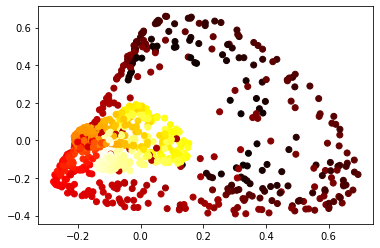

In [60]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

### Selecting a Kernel

In [61]:
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [62]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [63]:
best_pca = KernelPCA(
    n_components=2,
    gamma=grid_search.best_params_['kpca__gamma'],
    kernel=grid_search.best_params_['kpca__kernel']
)
X_reduced = rbf_pca.fit_transform(X)

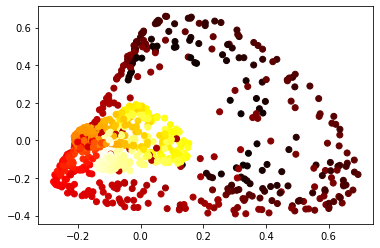

In [64]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

In [68]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.4333, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [69]:
mean_squared_error(X, X_preimage)

41.678079922976494

### LLE

In [78]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

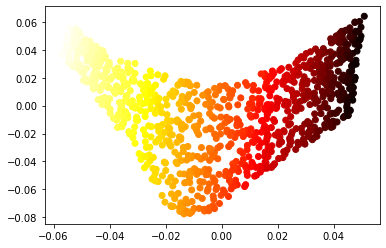

In [79]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
